# 6.843 Final Project: The BBT with the DEKA LUKE arm

TODO:
 - upload .sdf and meshes so arm can be imported into Drake
 - add two bins to Meshcat
 - generate the random blocks

In [ ]:
# Imports
import os
import time

import numpy as np
from IPython.display import display, HTML, clear_output
from functools import partial
import matplotlib.pyplot as plt
import open3d as o3d
from pydrake.examples.manipulation_station import ManipulationStation

# TODO(russt): Clean these up.
from pydrake.all import ( 
    AddMultibodyPlantSceneGraph, MeshcatVisualizerCpp, MeshcatVisualizerParams,
    DiagramBuilder, RigidTransform, RotationMatrix, Box,    
    CoulombFriction, FindResourceOrThrow, FixedOffsetFrame, 
    # MeshcatContactVisualizerCpp, MeshcatContactVisualizerParams, 
    Parser, PlanarJoint,  PointCloud,
    JointIndex, Simulator, ProcessModelDirectives, LoadModelDirectives,
    ConnectPlanarSceneGraphVisualizer,
    DrakeVisualizer, 
    DepthRenderCamera, RenderCameraCore, RgbdSensor, CameraInfo, ClippingRange, DepthRange,
    RandomGenerator, UniformlyRandomRotationMatrix, RollPitchYaw,
    MakeRenderEngineVtk, RenderEngineVtkParams, UnitInertia,
    Sphere, Cylinder, Box, Capsule, Ellipsoid, SpatialInertia, Rgba,
    MultibodyPlant, Solve, PiecewisePolynomial, PiecewiseQuaternionSlerp,
    TrajectorySource, ConstantVectorSource
)

from manipulation.open3d_utils import create_open3d_point_cloud
from manipulation.scenarios import AddRgbdSensors, AddFloatingRpyJoint
from manipulation.utils import FindResource, AddPackagePaths
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial
from manipulation.scenarios import AddMultibodyTriad

from manipulation.meshcat_cpp_utils import (
  StartMeshcat, draw_open3d_point_cloud, AddMeshcatTriad #, MeshcatJointSlidersThatPublish
)
from manipulation import running_as_notebook

if running_as_notebook and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

Meshcat is now available at https://ef5a0723-ec41-46ae-9da5-e5b53e81ff29.deepnoteproject.com


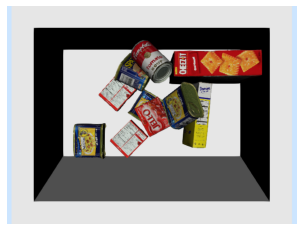

In [ ]:
def clutter_gen():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0005)

    parser = Parser(plant)

    parser.AddModelFromFile(FindResourceOrThrow(
        "drake/examples/manipulation_station/models/bin.sdf"))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base"))


    rs = np.random.RandomState()  # this is for python
    for i in range(25):
        #object_num = rs.randint(len(ycb))
        #sdf = FindResourceOrThrow("drake/manipulation/models/ycb/sdf/" + ycb[object_num][1])
        #parser.AddModelFromFile(sdf, f"object{i}")
        pass

    plant.Finalize()

    # TODO(russt): Use scenarios.
    renderer = "my_renderer"
    scene_graph.AddRenderer(
        renderer, MakeRenderEngineVtk(RenderEngineVtkParams()))
    depth_camera = DepthRenderCamera(RenderCameraCore(
        renderer, CameraInfo(width=640, height=480, fov_y=np.pi / 4.0),
        ClippingRange(near=0.1, far=10.0),
        RigidTransform()),
        DepthRange(0.1, 10.0))
    camera = builder.AddSystem(
        RgbdSensor(parent_id=scene_graph.world_frame_id(),
                   X_PB=RigidTransform(
                       RollPitchYaw(np.pi, 0, np.pi/2.0),
                       [0, 0, .8]),
                   depth_camera=depth_camera,
                   show_window=False))
    camera.set_name("rgbd_sensor")
    builder.Connect(scene_graph.get_query_output_port(),
                    camera.query_object_input_port())
    builder.ExportOutput(camera.color_image_output_port(), "color_image")

    # Note: if you're running this on a local machine, then you can 
    # use drake_visualizer to see the simulation.  (It's too slow to 
    # show the meshes on meshcat).
    vis = DrakeVisualizer.AddToBuilder(
        builder, 
        scene_graph
    )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    z = 0.1
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(
                UniformlyRandomRotationMatrix(generator),  
                [rs.uniform(-.15,.15), rs.uniform(-.2, .2), z])
        plant.SetFreeBodyPose(plant_context, 
                              plant.get_body(body_index),
                              tf)
        z += 0.1

    simulator.AdvanceTo(1.0 if running_as_notebook else 0.1)
    color_image = diagram.GetOutputPort("color_image").Eval(context)
    plt.figure()
    plt.imshow(color_image.data)
    plt.axis('off')

clutter_gen()

In [ ]:
def setup_plant():
  """Loads robot arm into Meshcat."""
  robot_path = "./luke_hand_description_6843/luke_hand_simple_shapes_both.URDF"
  # robot_path = "./mpl_right_arm/model.sdf"
  
  builder = DiagramBuilder()
  sim_timestep = 1e-3
  plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_timestep)
  
  parser = Parser(plant, scene_graph)
  pkg_map = parser.package_map()
  pkg_map.AddPackageXml("./luke_hand_description_6843/package.xml")
  model = parser.AddModelFromFile(robot_path)
  plant.Finalize()

  meshcat.Delete()
  visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
  diagram = builder.Build()
  context = diagram.CreateDefaultContext()

  link_frame_indices = []
  body_indices = plant.GetBodyIndices(model)
  for body in body_indices:
    link_frame_indices.append(plant.get_body(body).body_frame())

  diagram.Publish(context)

  return plant, link_frame_indices

# Get initial pose of the gripper by using default context of manip station.
plant, link_frame_indices = setup_plant()
for i in link_frame_indices:
  print(i)

<BodyFrame_[float] name='WR_Base-1' index=1 model_instance=2>
<BodyFrame_[float] name='WR_Forearm-1' index=2 model_instance=2>
<BodyFrame_[float] name='WFD_Gearbox-1' index=3 model_instance=2>
<BodyFrame_[float] name='Palm-1' index=4 model_instance=2>
<BodyFrame_[float] name='Thumb_Gear-1' index=5 model_instance=2>
<BodyFrame_[float] name='Distal_Thumb-1' index=6 model_instance=2>
<BodyFrame_[float] name='dklu-38013-001' index=7 model_instance=2>
<BodyFrame_[float] name='Index_Proximal-1' index=8 model_instance=2>
<BodyFrame_[float] name='Index_Distal-1' index=9 model_instance=2>
<BodyFrame_[float] name='dklu-38014-0011-1' index=10 model_instance=2>
<BodyFrame_[float] name='MRP_Differential' index=11 model_instance=2>
<BodyFrame_[float] name='Middle_Proximal-1' index=12 model_instance=2>
<BodyFrame_[float] name='Middle_Ring_Median-1' index=13 model_instance=2>
<BodyFrame_[float] name='Middle_Ring_Distal-1' index=14 model_instance=2>
<BodyFrame_[float] name='dklu-38015-001-1' index=15 m

In [ ]:
meshcat.Delete()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ef5a0723-ec41-46ae-9da5-e5b53e81ff29' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>